<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

Цель проекта - построение модели, способной определять возраст покупателя на фотографиях, сделанных в прикассовой зоне супермаркета. На основании этой информации, супермаркет сможет:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

В рамках проекта проведем:
- Исследовательский анализ данных;
- Подготовим данные для обучения модели;
- Обучим нейронную сеть ResNet50 и оценим её качество.

## Исследовательский анализ данных

In [1]:
# Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Загрузка изображений и меток только из локального хранилища, 
# так как код будет выполняться только на серверах Яндекс
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Оценим наличие пропусков:
file_name    0
real_age     0
dtype: int64
* * * * * * * * * * * * * * * * * * * * 
Размер данных с разметкой: (7591, 2)
Количество фотографий: 7591
* * * * * * * * * * * * * * * * * * * * 
Образцы объектов таблицы меток:
       file_name  real_age
5011  005011.jpg        80
731   000731.jpg        21
6615  006620.jpg        16
1278  001278.jpg        11
1643  001643.jpg        35
* * * * * * * * * * * * * * * * * * * * 
Основная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
* * * * * * * * * * * * * * * * * * * * 


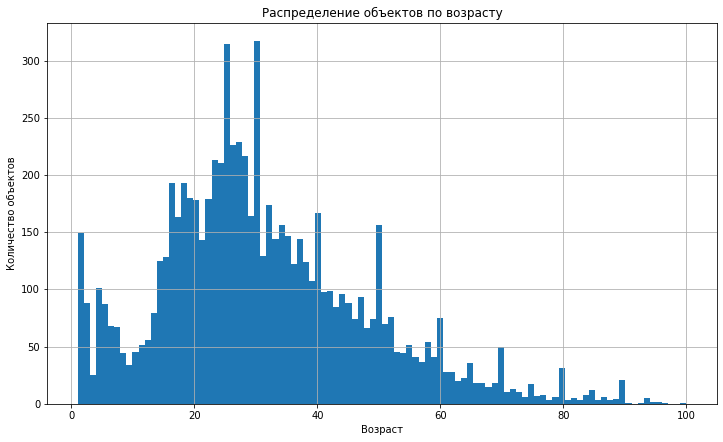

In [3]:
print('Оценим наличие пропусков:')
print(labels.isna().sum())
print('* ' * 20)
print('Размер данных с разметкой:',labels.shape)
print('Количество фотографий:',train_gen_flow.samples)
print('* ' * 20)
print('Образцы объектов таблицы меток:')
print(labels.sample(5))
print('* ' * 20)
print('Основная информация о датафрейме:')
print(labels.info())
print('* ' * 20)
fig = plt.figure(figsize=(12,7))
plt.title('Распределение объектов по возрасту')
plt.ylabel('Количество объектов')
plt.xlabel('Возраст')
labels['real_age'].hist(bins=100)
plt.show()

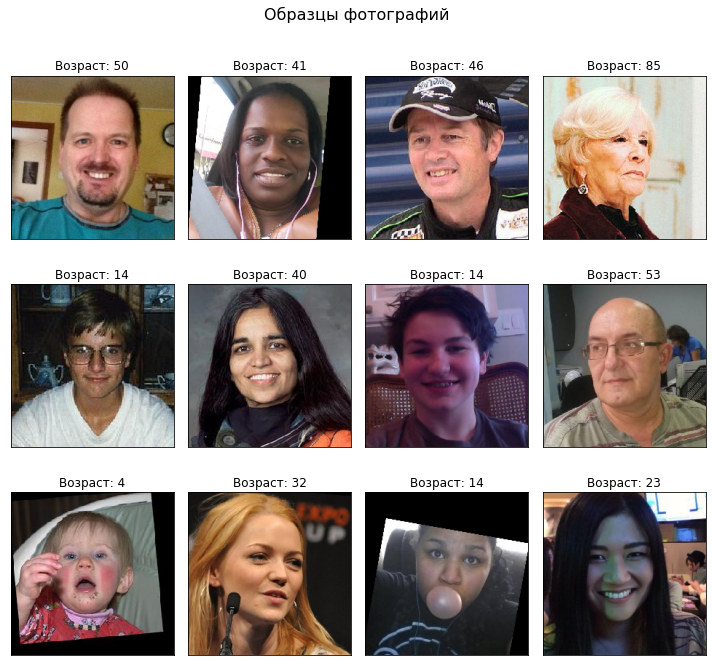

In [4]:
features, target = next(train_gen_flow)
# Выводим 12 изображений
fig = plt.figure(figsize=(10,10))
fig.suptitle("Образцы фотографий", fontsize=16)
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Выводы:**

- В нашем распоряжении датасет из **7591 размеченных фотографий** людей в возрасте от 1 до 100 лет. 
- Размер выборки достаточно мал для точного обучения модели, данную проблему частично можно решить аугментацией, но лучшим решением будет создание выборки бОльшего размера.
- Особенно критичен маленький размер выборки для возраста до 20 лет, **это может осложнить внедрение алгоритма определения возраста в целях контроля продажи алкоголя.**
- Выбросов и пропусков в данных нет. Распределение возраста скошено вправо, что является нормальным, так как отражает реальное распределение возраста людей. 
- На небольшой части фотографий кадры немного обрезаны в результате их поворота, присутствуют предметы, частично закрывающие лицо.
- Некоторые фотографии затемнены, а некоторые пересвечены, по этой причине **будет применена аугментация по уровню яркости.**
- В датасете отсутсвуют повернутые или перевернутые фотографии, все они похожи на то, как может выглядеть человек на кассе. **По этой причине аугментацию вертикального переворота и ротации применять не будем.**
- Перед обучением модели ResNet будет проведена нормализация и аугментация изображений с помощью ImageDataGenerator. Это поможет нам увеличить размер выборки и привести изображения к нормализованному виду.

## Обучение модели

Проведем аугментацию согласно выводам первой части работы и обучим модель ResNet50 на облачном сервере с GPU. Метрикой оценки качества модели будет MAE - Mean Absolute Error.

**Выводы:**

В рамках проекта была использованна модель нейронной сети ResNet50, предварительно обученная на наборе данных "imagenet". Модель была успешно обучена и проверена на валидационной выборке, показав метрику MAE, равную 6.149. Условием задания было добиться MAE < 8, что было успешно реализовано.

## Анализ обученной модели

В нашем распоряжении был датасет из **7591 размеченных фотографий** людей в возрасте от 1 до 100 лет. Перед обучением модели была произведена аугментация по уровню яркости изображения, горизонтальному перевороту и смещению по горизонтали. Также, была произведена нормализация изображений.

На основании обработанных данных была использованна модель нейронной сети ResNet50, предварительно обученная на наборе данных "imagenet". Модель была успешно обучена и проверена на валидационной выборке, показав метрику MAE, равную 6.149.

Применение данной модели будет целесообразным решением для первой задачи, а именно для анализа покупок и построения рекомендаций товаров для возрастной группы клиента, так как погрешность в 6 лет здесь не будет критичной.

Применение модели в целях контроля добросовестности кассиров при продаже алкоголя будет осложнено недостаточной точностью модели, так как погрешность в 6 лет будет весьма существенной в данном вопросе.

Для применения модели ко второй задаче можем рекомендовать использовать более широкую выборку фотографий, особенно для возрастной группы до 25 лет.